In [1]:
from utils import *
from SolarFlareNet_test import *

In [2]:
Window = [24]
Class = ["M"]
feature_names = 'TOTUSJH,TOTUSJZ,USFLUX,MEANALP,R_VALUE,TOTPOT,SAVNCPP,AREA_ACR,ABSNJZH'.split(',')

In [3]:
from PIL import Image

def combine_images(columns, space, images, fname):
    rows = len(images) // columns
    if len(images) % columns:
        rows += 1
    width_max = max([Image.open(image).width for image in images])
    height_max = max([Image.open(image).height for image in images])
    background_width = width_max*columns + (space*columns)-space
    background_height = height_max*rows + (space*rows)-space
    background = Image.new('RGBA', (background_width, background_height), (255, 255, 255, 255))
    x = 0
    y = 0
    for i, image in enumerate(images):
        img = Image.open(image)
        x_offset = int((width_max-img.width)/2)
        y_offset = int((height_max-img.height)/2)
        background.paste(img, (x+x_offset, y+y_offset))
        x += width_max + space
        if (i+1) % columns == 0:
            y += height_max + space
            x = 0
    background.save('%s' %fname)

In [4]:
# Create directories to save plots

def create_plot_dir(path):
    os.makedirs(path,  exist_ok=True)
    return

In [5]:
"""
#Train existing models for SolarFlareNet C,M, and M5 flares for  24, 47, and 72 hours.
#You change the values to limit the flare types and number of hours to train.
print('Loading the train_model function...')
from SolarFlareNet_train import *
for time_window in Window:
    for flare_class in Class:
        train(str(time_window), flare_class)
        log('===========================================================\n\n',verbose=True)
"""

"\n#Train existing models for SolarFlareNet C,M, and M5 flares for  24, 47, and 72 hours.\n#You change the values to limit the flare types and number of hours to train.\nprint('Loading the train_model function...')\nfrom SolarFlareNet_train import *\nfor time_window in Window:\n    for flare_class in Class:\n        train(str(time_window), flare_class)\n        log('===========================================================\n\n',verbose=True)\n"

Python version: 3.11.5
Tensorflow bakcend version: 2.14.0

[2024-01-02 19:06:24] Testing is initiated for time_window: 24 and flare class: M 
[2024-01-02 19:06:24] loading data from file: data/training_data_M_24.csv 
[2024-01-02 19:06:26] loading data from file: data/testing_data_M_24.csv 
[2024-01-02 19:06:27] Loading weights from model dir: interpret_models/24/M 
[2024-01-02 19:06:27] Predicting test data set samples.. 
[2024-01-02 19:06:30] Saving result to file: result/SolarFlareNet/M_24.csv 
[2024-01-02 19:06:30] ===========================================================

 
Interpreting using ALE method
[[False  True  True  True  True  True  True  True  True]
 [False False  True  True  True  True  True  True  True]
 [False False False  True  True  True  True  True  True]
 [False False False False  True  True  True  True  True]
 [False False False False False  True  True  True  True]
 [False False False False False False  True  True  True]
 [False False False False False False Fal

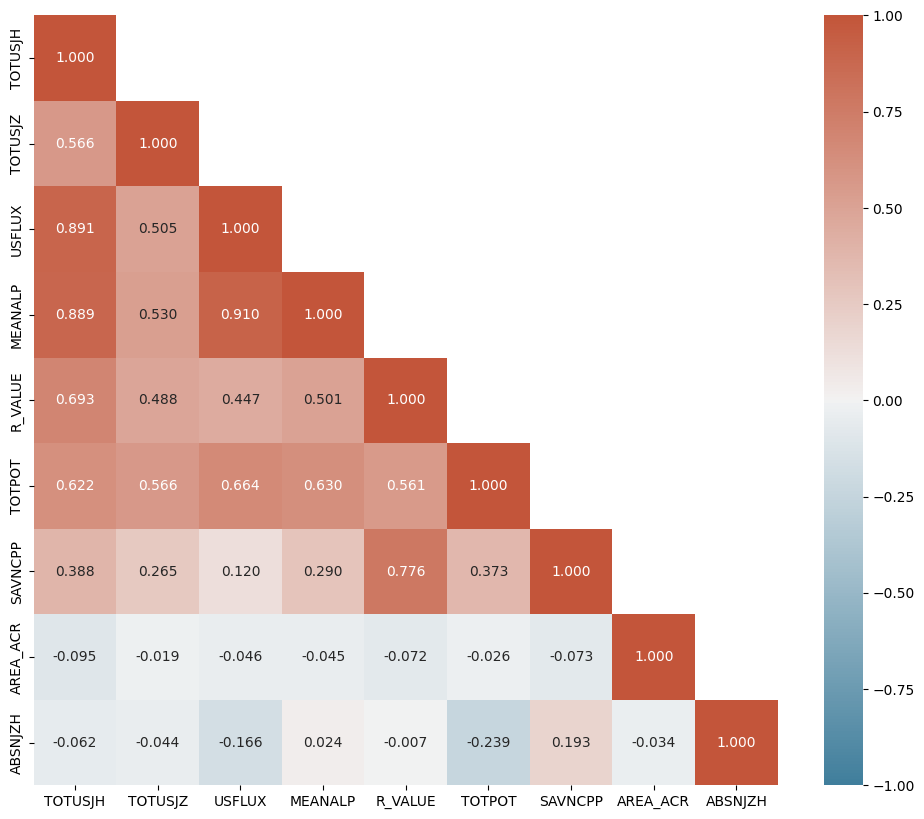

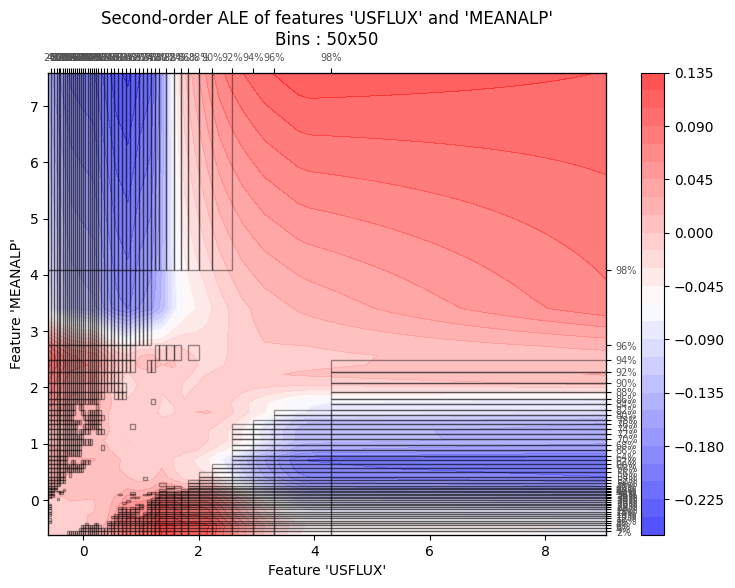

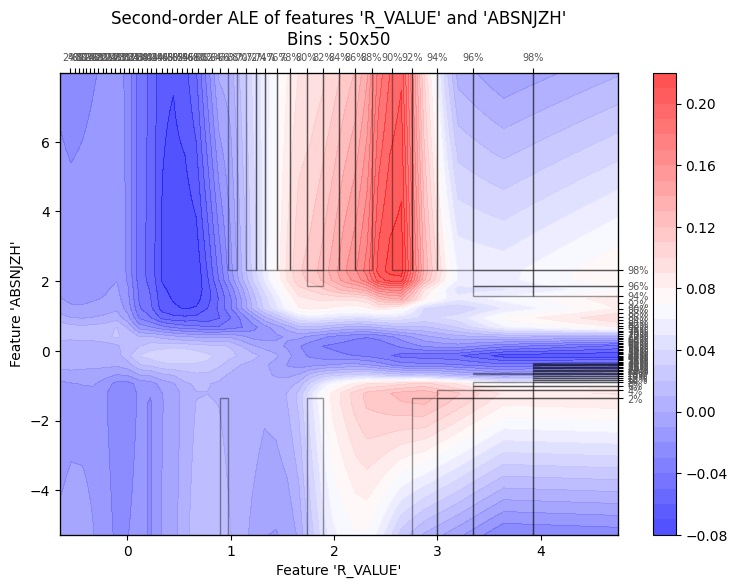

In [6]:
#Dependencies
#!pip install lime (to run LIME)
#!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython (to run ALE)
#!pip install alibi[ray] (to run ALE)
#!pip install shap (to run SHAP)
#!pip install timeshap (to run SHAP)

from lime.lime_tabular import RecurrentTabularExplainer
from alibi.explainers import KernelShap
from alibi.explainers import ALE, plot_ale
from alepython import ale_plot
#import shap
#from shap import DeepExplainer
#import timeshap
#from timeshap.explainer import local_pruning, local_event, local_feat, local_cell_level
#from timeshap.plot import plot_temp_coalition_pruning, plot_event_heatmap, plot_feat_barplot, plot_cell_level
import matplotlib.pyplot as plt
import seaborn as sb

#Test existing models for SolarFlareNet C,M, and M5 flares for  24, 47, and 72 hours.
#You change the values to limit the flare types and number of hours to test.

# You change the tools listed in the interpretable_tools dict for using a specific tool to interpret
# LIME key takes a list of instances or a slice which consideres instances upto that range (i.e. example slice(1000)-> [:1000])
# ALE key takes a list containg types of plot we want. ["1D", "2D"]
# SHAP tool is not yet implemented.
# limit is the number of test cases considered to generate the results.

interpretable_tools = {"LIM":[[15], "slice(1000)"], "ALE":["1Dh", "2D"], "SHA":3}
tool_fn = lambda x: print("Interpreting using %s method" %x)
limit = 50000
top_features = []

for time_window in Window:
    for flare_class in Class:
        model, train_data, test_data = test(str(time_window), flare_class)
        X_train, y_train, X_test, y_test = train_data[0][:limit], train_data[1][:limit], test_data[0][:limit], test_data[1][:limit]
        #model.summary()
        log('===========================================================\n\n',verbose=True)
        for tool in interpretable_tools:
            if tool == "LIME":
                tool_fn(tool)
                model_mask = model.get_model()
                explainer = RecurrentTabularExplainer(X_train, training_labels=y_train, feature_names=feature_names,
                                                    discretize_continuous=True, verbose=False, feature_selection='none',
                                                    class_names=['Negative', 'Positive'], discretizer='decile')
                instances = interpretable_tools[tool]
                for instance in instances:
                    if isinstance(instance, list):
                        plt_dir = tool + os.sep + "%d_%s" %(time_window,flare_class)
                        path_fn = lambda x: plt_dir + os.sep + "%s.html" %x
                        create_plot_dir(plt_dir)
                        for i in instance:
                            exp = explainer.explain_instance(X_test[i], model_mask.predict, num_features=len(feature_names), num_samples=5000)
                            exp.show_in_notebook()
                            #exp.as_pyplot_figure()
                            exp.save_to_file(file_path=path_fn("%d_%s_%d" %(time_window, flare_class, i)))
                    elif isinstance(instance, slice):
                        feature_rank = {x:[] for x in feature_names}
                        for data in X_test[instance]:
                            exp = explainer.explain_instance(data, model_mask.predict, num_features=len(feature_names), num_samples=5000)
                            exp_map = exp.as_map()
                            for k, rank in enumerate(exp_map[1]):
                                feature_rank[feature_names[rank[0]]].append(k+1)
                        feature_rank = pd.DataFrame(feature_rank)
                        final_ranking = feature_rank.mean().sort_values()
                        print(final_ranking)
                        ranking = final_ranking.to_dict()
            elif tool == "ALE":
                tool_fn(tool)
                plot_type = interpretable_tools[tool]
                for plt_type in plot_type:
                    plt_dir = tool + os.sep + plt_type + os.sep + "%d_%s" %(time_window, flare_class)
                    path_fn = lambda x: plt_dir + os.sep + "%s" %x
                    if plt_type == "1D":
                        create_plot_dir(plt_dir)
                        """
                        ale = ALE(model.predict, feature_names=feature_names, target_names=["Label"])
                        ale_exp = ale.explain(np.squeeze(X_train), min_bin_points=20)
                        ax_1d = plot_ale(ale_exp, n_cols=3, sharey=None, fig_kw={'figwidth':14, 'figheight': 10})
                        fig_1d = ax_1d[0][0].get_figure()
                        fig_1d.savefig(path_fn("%d_%s" %(time_window, flare_class)))
                        """
                        X_train_df = pd.DataFrame(np.squeeze(X_train), columns=feature_names)
                        figures = []
                        fig = plt.figure()
                        for i,f1 in enumerate(feature_names):
                            ax_1d = ale_plot(model, X_train_df, f1, bins=10, monte_carlo=True, monte_carlo_rep=50)
                            ax_1d.set_title("First-order ALE of feature '%s'" %f1)
                            fig_1d = ax_1d.get_figure()
                            fig_1d.savefig(path_fn("%s.png" %f1))
                            figures += [path_fn("%s.png" %f1)]
                            #fig.add_axes(ax_1d)    #WARNING exicuting this generates a ValueError: The Axes must have been created in the present figure
                        if len(figures) == len(feature_names):
                            combine_images(3, 0, figures, path_fn("%d_%s.pdf" %(time_window, flare_class)))
                    elif plt_type == "2D":
                        create_plot_dir(plt_dir)
                        X_train_df = pd.DataFrame(np.squeeze(X_train), columns=feature_names)
                        corr = X_train_df.corr(method='pearson')
                        sorted_corr = corr.replace(1.0, np.nan).unstack().dropna().sort_values(ascending=False, key=abs).drop_duplicates().to_dict()
                        assert len(sorted_corr) == math.comb(len(feature_names),2)
                        ranked_corr = list(sorted_corr.keys())
                        mask = np.triu(np.ones_like(corr, dtype=bool), 1)
                        print(mask)
                        cmap = sb.diverging_palette(230, 20, as_cmap=True)
                        fig = plt.figure(figsize=(12,10))
                        ax = sb.heatmap(corr, vmin=-1, vmax=1, cmap=cmap, mask=mask, annot=True, fmt='.3f')
                        fig.savefig(path_fn("corr_heatmap.pdf"))
                        plt.show()
                        figures = []
                        plt.rc("figure", figsize=(9,6))
                        for i, f1 in enumerate(feature_names):
                            for f2 in feature_names[i:]:
                                if f1 != f2:
                                    #figures += [path_fn("%s_vs_%s.png" %(f1,f2))]
                                    if (f1 in ranked_corr[0] and f2 in ranked_corr[0]) or (f1 in ranked_corr[-1] and f2 in ranked_corr[-1]):
                                        ax_2d = ale_plot(model, X_train_df, [f1,f2], bins=50)
                                        fig_2d = ax_2d.get_figure()
                                        fig_2d.savefig(path_fn("%s_vs_%s.pdf" %(f1,f2)))
                        if len(figures) == math.comb(len(feature_names),2):
                            combine_images(6, 0, figures, path_fn("%d_%s.pdf" %(time_window, flare_class)))
            elif tool == "SHAP":
                tool_fn(tool)
                model_mask = model.get_model()
                instance = interpretable_tools[tool]

                """explainer = DeepExplainer(model_mask, X_train)
                shap_values = explainer.shap_values(X_test[(instance-1):instance], check_additivity=False)
                expected_value = explainer.expected_value
                shap.plots.initjs()
                display(shap.decision_plot(expected_value[0], shap_values[0][0], feature_names))
                display(shap.force_plot(expected_value[0], shap_values[0][0], feature_names=feature_names, 
                                        matplotlib=True, contribution_threshold=0.005))
                
                predict_fn = lambda x: model.predict(x)
                explainer = KernelShap(predict_fn, link='logit', feature_names=feature_names)
                explainer.fit(np.squeeze(X_train[:5000]))
                explanation = explainer.explain(np.squeeze(X_test)[(instance-1):instance])"""
                
                
                